# Instalación de librerías necesarías

In [ ]:
!python --version

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install umap-learn

# Importar librerías necesarias

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange  #for progress bars
import pandas as pd
import io
import os # accessing directory structure
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image #for image rendering
import os
import umap

# Carga de Datos

In [4]:
import google as goo
goo.colab.drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
data_partitions_dirpath = '/content/drive/My Drive/Colab Notebooks/data/PFAM'
print('Available dataset partitions: ', os.listdir(data_partitions_dirpath))

Available dataset partitions:  ['dev']


In [7]:
def read_all_shards(partition='dev', data_dir=data_partitions_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    return pd.concat(shards)

#test = read_all_shards('test')
dev = read_all_shards('dev')
#train = read_all_shards('train')

#partitions = {'test': test, 'dev': dev, 'train': train}
partitions = {'dev': dev}
for name, df in partitions.items():
    print('Dataset partition "%s" has %d sequences' % (name, len(df)))

Dataset partition "dev" has 126171 sequences


In [11]:
dev.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,Ribosomal_L9_N,RL9_THEM4/1-47,PF01281.19,MKVVLLKDVS.KIGKKGEIKNVSDGYARNYL.IPKGLALEATPRVLKRL,MKVVLLKDVSKIGKKGEIKNVSDGYARNYLIPKGLALEATPRVLKRL
1,Ribosomal_L23,F4KWU5_HALH1/5-95,PF00276.20,DILI.........QPLI.TEKT.E......KLS............S...,DILIQPLITEKTEKLSSSLNKYSFIVHRKANKVEIKKAVEAFYGVT...
2,DUF1996,H6BXS5_EXODN/37-270,PF09362.10,DPIISPGGI..SGHCHTIAGPN......NLNT.TS.TFDSLQ.......,DPIISPGGISGHCHTIAGPNNLNTTSTFDSLQASYCTSCSIQKDKS...
3,DDE_Tnp_1_6,Q63SM4_BURPS/325-443,PF13751.6,VCPQGQAL.PYSTT.NRLG..YREYKS.....NA.QICGRCPVRSQ...,VCPQGQALPYSTTNRLGYREYKSNAQICGRCPVRSQCTNSAIAVKV...
4,CHAP,D5UFK8_CELFN/144-237,PF05257.16,TSTN.TG.V....W.D.QCT.......W.GA.............KE...,TSTNTGVWDQCTWGAKEKFREYSGVYPNITGNARQWYDSARANGWT...


## Elegimos aquellas familias de proteinas que presentan una mayor frecuencia en el dataset
__Las familias con un mayor número de secuencias__

In [8]:
dev.groupby('family_id').size().sort_values(ascending=False).head(10)

,0
family_id,
Methyltransf_25,454
LRR_1,240
Acetyltransf_7,219
His_kinase,192
Bac_transf,190
Lum_binding,187
DNA_binding_1,168
Chromate_transp,157
Lipase_GDSL_2,156


In [9]:
## Se toman las 10 familias de mayor frecuencia
Familias = ['Methyltransf_25','LRR_1','Acetyltransf_7','His_kinase','Bac_transf','Lum_binding','DNA_binding_1','Chromate_transp',
            'Lipase_GDSL_2','DnaJ_CXXCXGXG']

# Extracción de incrustaciones ("embeddings") para caracterizar de forma abstracta las proteinas

Para este ejercicio se amplia el número de familias, adoptando las 10 más frecuentes. Por otro lado se reduce el número de elementos por familia (hasta 20) porque no se va a realizar ningún proceso de ajuste fino, sino una __inferencia__ de las incrustaciones para caracterizar las proteinas.

In [12]:
maxNumFamily = 500 # Máximo número de proteinas en una de las familias seleccionadas
numSelectFamily = len(Familias) # numero de familias seleccionadas
total = np.zeros(numSelectFamily)
sequences = []
labels = []
for i in tqdm(range(dev.values.shape[0])):
    if dev.values[i][0] in Familias:
        ID = Familias.index(dev.values[i][0])
        if total[ID]<maxNumFamily:
            total[ID] += 1
            sequences.append(dev.values[i][4])
            labels.append(ID)

100%|██████████| 126171/126171 [00:00<00:00, 293898.18it/s]


In [13]:
len(sequences), len(labels)

(2114, 2114)

### Se aplica el modelo ProtT5

Para generar las incrustaciones de los aminoacidos de las proteinas se adopta el modelo __ProtT5__, que también se basa en un __Encoder__ y que aparece en el trabajo de los autores:

<a href="https://ieeexplore.ieee.org/abstract/document/9477085">ProtTrans: Toward Understanding the Language of Life Through Self-Supervised Learning (Elnaggar et al., 2022)</a>

<a href="https://github.com/agemagician/ProtTrans/">Se puede acceder a ejemplos de código ProtTrans en GitHub</a>

In [14]:
from transformers import T5Tokenizer, T5EncoderModel
tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False, legacy=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc").to(device)
model

pytorch_model.bin:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

T5EncoderModel(
  (shared): Embedding(128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)
              (dropout): Dropo

In [17]:
# only GPUs support half-precision currently; if you want to run on CPU use full-precision (not recommended, much slower)
if device == torch.device("cpu"):
    model.to(torch.float32)

In [18]:
import re
# replace all rare/ambiguous amino acids by X and introduce white-space between all amino acids
sequence_examples = [" ".join(list(re.sub(r"[UZOB]", "X", sequence))) for sequence in sequences]
sequence_examples[0]

'K R L F D F L A S L M G L L I I S P F M L M L S I G V K L S S P G P I F Y G Q E R V G I N G R K F N M W K F R S M R V A N D N E D Q T T W S S K E D P R K T K F G S F I R S T S L D E L P Q L W N V L I G D M S L V G P R P E R T F F V E K F K N E I P N Y M L R H K M K A G I T G W A Q V N G W R G D T D L S K R I E C D I Y Y I R N W S L I L D F K I L L L T F V K G F I'

In [19]:
# tokenize sequences and pad up to the longest sequence in the batch
# ids = tokenizer.batch_encode_plus(sequence_examples, add_special_tokens=True, padding="longest")
ids = tokenizer(sequence_examples, add_special_tokens=True, padding="longest")

input_ids = torch.tensor(ids['input_ids']).to(device)
attention_mask = torch.tensor(ids['attention_mask']).to(device)
input_ids[0]

tensor([14,  8,  4, 15, 10, 15,  4,  3,  7,  4, 19,  5,  4,  4, 12, 12,  7, 13,
        15, 19,  4, 19,  4,  7, 12,  5,  6, 14,  4,  7,  7, 13,  5, 13, 12, 15,
        18,  5, 16,  9,  8,  6,  5, 12, 17,  5,  8, 14, 15, 17, 19, 21, 14, 15,
         8,  7, 19,  8,  6,  3, 17, 10, 17,  9, 10, 16, 11, 11, 21,  7,  7, 14,
         9, 10, 13,  8, 14, 11, 14, 15,  5,  7, 15, 12,  8,  7, 11,  7,  4, 10,
         9,  4, 13, 16,  4, 21, 17,  6,  4, 12,  5, 10, 19,  7,  4,  6,  5, 13,
         8, 13,  9,  8, 11, 15, 15,  6,  9, 14, 15, 14, 17,  9, 12, 13, 17, 18,
        19,  4,  8, 20, 14, 19, 14,  3,  5, 12, 11,  5, 21,  3, 16,  6, 17,  5,
        21,  8,  5, 10, 11, 10,  4,  7, 14,  8, 12,  9, 22, 10, 12, 18, 18, 12,
         8, 17, 21,  7,  4, 12,  4, 10, 15, 14, 12,  4,  4,  4, 11, 15,  6, 14,
         5, 15, 12,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 

In [20]:
input_ids.shape, attention_mask.shape

(torch.Size([2114, 274]), torch.Size([2114, 274]))

In [21]:
attention_mask[0:5]

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')

In [22]:
# generate embeddings
embedding_repr = []
with torch.no_grad():
    for i in tqdm(range(0, input_ids.shape[0], 10)):
        embed_Block = model(input_ids=input_ids[i:i + 10], attention_mask=attention_mask[i:i+10]).last_hidden_state
        for k in range(embed_Block.shape[0]):
            embedding_repr.append(embed_Block[k])


100%|██████████| 212/212 [07:48<00:00,  2.21s/it]


### Adoptar una incrustación única por proteina

__La incrustación única es el vector media de las posiciones no enmascaradas__

In [23]:
lstFullProtein = []
for iP in range(len(embedding_repr)):
    if attention_mask[iP][-1]==1:
        fullProtein = embedding_repr[iP].mean(dim=0) # shape (1024)
    else:
        if device == torch.device("cpu"):
            ix = np.where(attention_mask[iP].numpy()==0)[0][0]
        else:
            ix = np.where(attention_mask[iP].cpu()==0)[0][0]
        fullProtein = embedding_repr[iP][0:ix].mean(dim=0) # shape (1024)
    if device == torch.device("cpu"):
      lstFullProtein.append(fullProtein.numpy())
    else:
      lstFullProtein.append(fullProtein.cpu())
arrLabels = np.asarray(labels)
arrFullProtein = np.asarray(lstFullProtein)

In [24]:
arrFullProtein.shape, arrLabels.shape

((2114, 1024), (2114,))

### Realizar una reducción dimensional para hacer una representación 2D

Se realiza una reducción para representar el resultado con el algoritmo __UMAP__.


https://arxiv.org/pdf/1802.03426

https://github.com/lmcinnes/umap

https://umap-learn.readthedocs.io/en/latest/basic_usage.html


In [25]:
reducer = umap.UMAP(random_state=42)
reducer.fit(arrFullProtein)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [26]:
X_umap = reducer.transform(arrFullProtein)
X_umap.shape

(2114, 2)

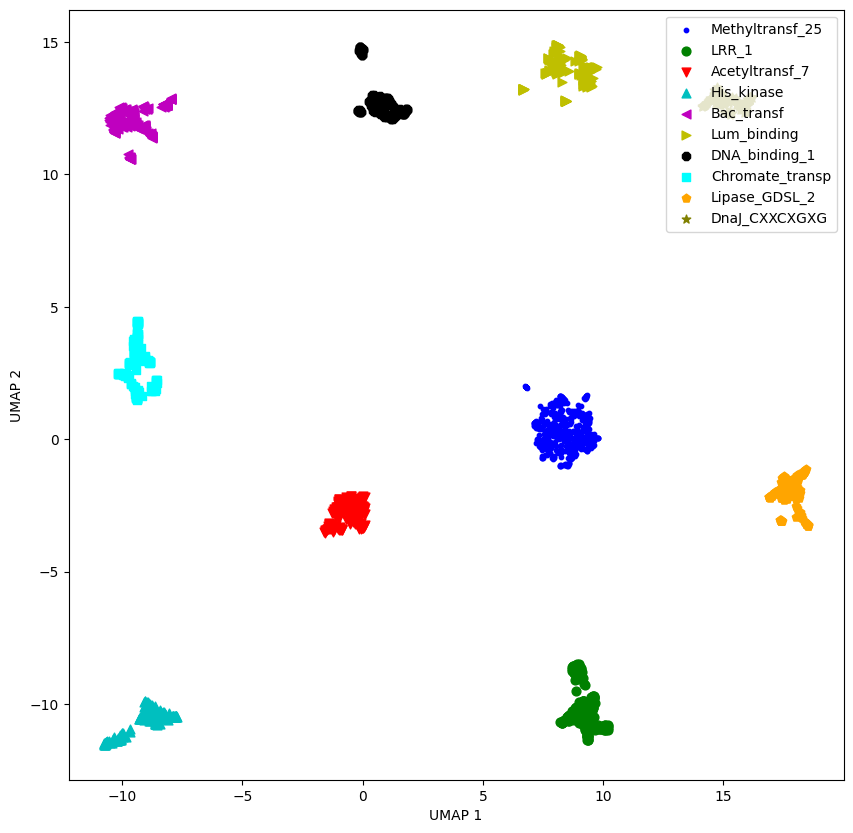

In [31]:
colors = ['b', 'g', 'r', 'c','m', 'y','k', 'aqua', 'orange', 'olive']
markers = ['.', 'o', 'v', '^', '<', '>', '8', 's', 'p', '*']
plt.subplots(figsize=(10, 10))
for l, c, m in zip(np.unique(arrLabels), colors, markers):
    plt.scatter(X_umap[arrLabels==l, 0], X_umap[arrLabels==l, 1], c=c, label=Familias[l], marker=m, s=40)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(loc='upper right')
plt.show()